In [8]:
import os
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [2]:
# Specify the directory path where files are located
directory_path = 'FUMA_downloads_all_tissue/SNPs'

# Initialize an empty list to store DataFrames
df_list = []

# Initialize an empty list to store disorder names
disorder_names = []

# Iterate through files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.txt'):  # Process only .txt files
        # Extract disorder name from the filename
        disorder_name = filename.split('_')[1].split('.')[0]
        disorder_names.append(disorder_name)

        # Read the file as a DataFrame
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(file_path, sep='\t')

        # Add a column with the disorder name
        df['disorder'] = disorder_name

        # Append the DataFrame to the list
        df_list.append(df)


In [3]:
# Extract unique SNP identifiers and DataFrame names
unique_snps = pd.concat([df['rsID'] for df in df_list], ignore_index=True).drop_duplicates()


# Create a dictionary to store the SNP data for each DataFrame
snp_data = {}
for df, df_name in zip(df_list, disorder_names):
    snp_data[df_name] = df['rsID'].tolist()

# Create a new DataFrame with unique SNP identifiers as rows and DataFrame names as columns
result_df = pd.DataFrame(index=unique_snps, columns=disorder_names)

# Fill in the DataFrame with SNP data
for df_name in disorder_names:
    result_df.loc[snp_data[df_name], df_name] = 1

# Fill NaN values with 0
result_df.fillna(0, inplace=True)
result_df.index.name= None

In [11]:
# #function to make a matrix with p-values between disorders and snps
# def p_value_matrix(dfs, df_names):
#     # Extract unique snp identifiers and DataFrame names
#     unique_snps = pd.concat([df['rsID'] for df in dfs if 'rsID' in df.columns],
#                             ignore_index=True).drop_duplicates()
# 
#     # Create a dictionary to store the snp data for each DataFrame
#     genes_data = {}
#     for df, df_name in zip(dfs, df_names):
#         if 'rsID' in df.columns:
#             genes_data[df_name] = df[df['rsID'].isin(unique_snps)]['rsID'].tolist()
# 
#     # Create a new DataFrame with unique snp identifiers as rows and DataFrame names as columns
#     result_df = pd.DataFrame(index=unique_snps, columns=df_names)
# 
#     # Fill in the DataFrame with snp data
#     for df_name in df_names:
#         if df_name in genes_data:
#             result_df.loc[genes_data[df_name], df_name] = dfs[df_names.index(df_name)]['gwasP'].values
# 
#     # Fill NaN values with 0
#     result_df.fillna(0, inplace=True)
# 
#     result_df.index.name = None
# 
#     return result_df

In [10]:
result_df.to_csv('output/snps_all_binary.txt', sep='\t')

In [19]:
result_df

,ADHD,ANOREXIA,ANXIETY,ARTHRITIS,ASD,AUD,BILIARY,BPD,CUD,FATIGUE,...,MIGRAINE,MS,MYASTHENIA,OCD,OD,PARKINSONS,PTSD,SCZ,SJOGRENS,TOURETTES
rs12743450,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
rs1295107,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
rs11121053,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
rs12566355,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
rs58801392,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rs12463058,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
rs12984081,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
rs570749136,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
rs57411594,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [36]:
result_df.sum(axis=0)

ADHD           22707
ANOREXIA        8448
ANXIETY          542
ARTHRITIS      26507
ASD             7263
AUD            12305
BILIARY        22373
CUD             4470
FATIGUE         1136
FIBROMYLGIA      548
GOUT            3432
HOARDING         636
IBS             6800
LUPUS          21222
MDD            37105
MIGRAINE        6566
MS              9917
MYASTHERIA      6018
OCD             1270
OD              1255
PARKINSONS     10429
PTSD            1163
TOURETTES       2284
dtype: int64

In [25]:
print((result_df.sum(axis=1) > 2).sum())

14103


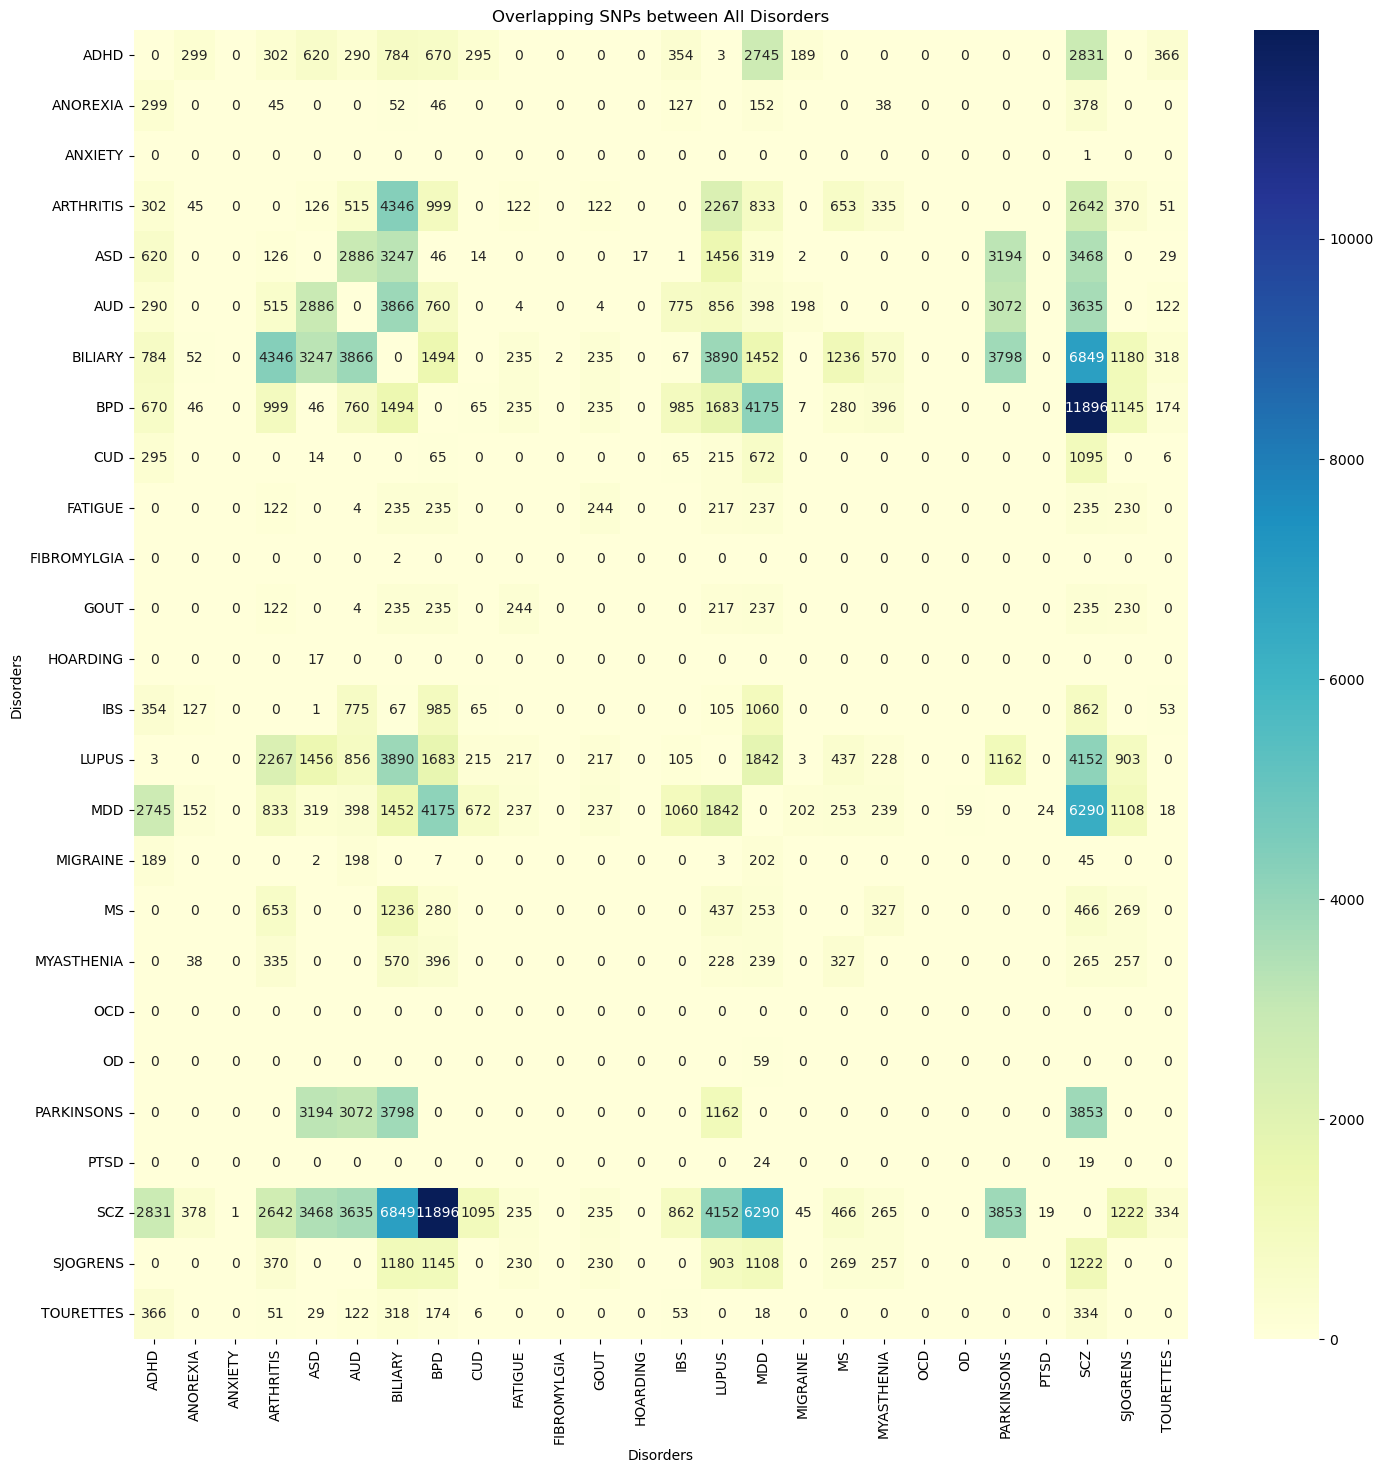

In [13]:
# Find overlapping SNPs between disorders
overlapping_snps = {}
for disorder1 in result_df.columns:
    overlapping_snps[disorder1] = []
    for disorder2 in result_df.columns:
        if disorder1 != disorder2:
            # Check for overlapping SNPs between two disorders
            common_snps = result_df[(result_df[disorder1] == 1) & (result_df[disorder2] == 1)].index.tolist()
            if common_snps:
                overlapping_snps[disorder1].append((disorder2, common_snps))

# Create a matrix to represent the overlaps between disorders
overlap_matrix = pd.DataFrame(index=overlapping_snps.keys(), columns=overlapping_snps.keys(), data=0)

# Fill the overlap matrix with the count of overlapping SNPs between disorders
for disorder, overlaps in overlapping_snps.items():
    for other_disorder, snps in overlaps:
        overlap_matrix.loc[disorder, other_disorder] = len(snps)

# Plotting the heatmap
plt.figure(figsize=(17,17))
sns.heatmap(overlap_matrix, annot=True, cmap="YlGnBu", fmt="d")
plt.title("Overlapping SNPs between All Disorders")
plt.xlabel("Disorders")
plt.ylabel("Disorders")
plt.show()